# DATA PREPARATION

In [2]:
import os #"""os used for file extraction"""
import glob #"""glob used for folder/file identification"""
import zipfile #"""zipfile used for unzipping"""
import numpy as np #"""numpy used for statistics purpose"""
import pandas as pd #"""pandas used for importing data and creating dataframes"""
import seaborn as sns #"""seaborn used for visulization"""
import matplotlib.pyplot as plt #"""matplot used for visulization"""
from datetime import timedelta, datetime
import warnings #"""warnings used to ignore warning windows"""
warnings.filterwarnings('ignore')

In [6]:
df = pd.DataFrame()

#Creating date time based on individual columns of time, date, start time, end time etc.
survey = pd.read_excel(r'SurveyResults.xlsx', usecols=['ID', 'Start time', 'End time', 'date', 'Stress level'], dtype={'ID': str})
survey['Stress level'].replace('na', np.nan, inplace=True)
survey.dropna(inplace=True)

survey['Start datetime'] =  pd.to_datetime(survey['date'].map(str) + ' ' + survey['Start time'].map(str))
survey['End datetime'] =  pd.to_datetime(survey['date'].map(str) + ' ' + survey['End time'].map(str))
survey.drop(['Start time', 'End time', 'date'], axis=1, inplace=True)

# Convert SurveyResults.xlsx to GMT-00:00
daylight = pd.to_datetime(datetime(2020, 11, 1, 0, 0))

survey1 = survey[survey['End datetime'] <= daylight].copy()
survey1['Start datetime'] = survey1['Start datetime'].apply(lambda x: x + timedelta(hours=5))
survey1['End datetime'] = survey1['End datetime'].apply(lambda x: x + timedelta(hours=5))

survey2 = survey.loc[survey['End datetime'] > daylight].copy()
survey2['Start datetime'] = survey2['Start datetime'].apply(lambda x: x + timedelta(hours=6))
survey2['End datetime'] = survey2['End datetime'].apply(lambda x: x + timedelta(hours=6))

survey = pd.concat([survey1, survey2], ignore_index=True)
survey['datetime'] = survey['End datetime'] - survey['Start datetime']

#Creating minutes columns for labeling 
def minutes(x):
    return x.seconds/60
survey['time'] = survey['datetime'].apply(minutes)
survey.reset_index(drop=True, inplace=True)

#"""Glob will help us access to all folders inside the specified location"""
folders = glob.glob(os.path.join("Stress_dataset/*"))

i = 0
#"""Looping through the folders so we can get all the data one by one and merge it into one single csv"""
while i < len(folders):
    
    #only running for one file. rest all fines is same
    if i == 1:
        break
    
    folder = folders[i]
    #"""Glob will help us access to all the files inside the folder"""
    files = glob.glob(os.path.join(folder, '*.zip'))
    #"""creating new dataframe to append all the data from each folder"""
    joined_list = pd.DataFrame()
    j = 0
    
    #"""looping through each files to unzip because each folder have multiple zip files and each zip file have
    #multiple csv we need to merge"""
    while j < len(files):
        file = files[j]
        
        #"""zipfile helps us unzip the files and access the csv. it will unzip in the .ipynb directory"""
        with zipfile.ZipFile(file) as zf:
            zf.extractall()
            #"""accessing the data"""
            acc = pd.read_csv('ACC.csv', index_col=None, header=0)
            bvp = pd.read_csv('BVP.csv', index_col=None, header=0)
            eda = pd.read_csv('EDA.csv', index_col=None, header=0)
            hr = pd.read_csv('HR.csv', index_col=None, header=0)
            temp = pd.read_csv('TEMP.csv', index_col=None, header=0)

            acc = acc.rename(columns={acc.columns[0]: 'acx', acc.columns[1]: 'acy', acc.columns[2]: 'acz'})
            bvp = bvp.rename(columns={bvp.columns[0]: 'blood_vol_pulse'})
            eda = eda.rename(columns={eda.columns[0]: 'eda'})
            hr = hr.rename(columns={hr.columns[0]: 'h_rate'})
            temp = temp.rename(columns={temp.columns[0]: 'temp'})
            print("Zip file extracted and extracted csv's")
            
            #Creating DateTime attribute for each dataset

            def process_df(df):
                start_timestamp = df.iloc[0,0]
                sample_rate = df.iloc[1,0]
                new_df = pd.DataFrame(df.iloc[2:].values, columns=df.columns)
                new_df['datetime'] = [(start_timestamp + i/sample_rate) for i in range(len(new_df))]
                return new_df
            
            acc = process_df(acc)
            bvp = process_df(bvp)
            eda = process_df(eda)
            hr = process_df(hr)
            temp = process_df(temp)
            print('Date Time Created')

            #Merging the Data #taken from original code because this was the best feasible method
            merged = acc.merge(eda, on='datetime', how='outer')
            merged = merged.merge(bvp, on='datetime', how='outer')
            merged = merged.merge(hr, on='datetime', how='outer')
            merged = merged.merge(temp, on='datetime', how='outer')
            print('Merging is done')
            
            #Fill all the null value by forward fill and backward fill instead of removing and losing the data
            
            merged.fillna(method='ffill', inplace=True)
            merged.fillna(method='bfill', inplace=True)
            merged.reset_index(inplace = True,drop = True)
            print('Fill null value is done')
            
            #"""appending the data of each folder to the variable"""
            joined_list = joined_list.append(merged)
                 
        j += 1
        joined_list['id'] = folders[i][-2:]
    #"""concating the folders together to final dataframe to save the csv at the end"""
    df = pd.concat([df,joined_list],ignore_index = True).reset_index(drop=True)
    
    print(i, ' :- is Done')
    i += 1
    
print('DONE')

Zip file extracted and extracted csv's
Date Time Created
Merging is done
Fill null value is done
Zip file extracted and extracted csv's
Date Time Created
Merging is done
Fill null value is done
Zip file extracted and extracted csv's
Date Time Created
Merging is done
Fill null value is done
Zip file extracted and extracted csv's
Date Time Created
Merging is done
Fill null value is done
Zip file extracted and extracted csv's
Date Time Created
Merging is done
Fill null value is done
Zip file extracted and extracted csv's
Date Time Created
Merging is done
Fill null value is done
Zip file extracted and extracted csv's
Date Time Created
Merging is done
Fill null value is done
Zip file extracted and extracted csv's
Date Time Created
Merging is done
Fill null value is done
Zip file extracted and extracted csv's
Date Time Created
Merging is done
Fill null value is done
Zip file extracted and extracted csv's
Date Time Created
Merging is done
Fill null value is done
Zip file extracted and extract

In [7]:
survey

,ID,Stress level,Start datetime,End datetime,datetime,time
0,5C,1.0,2020-04-15 13:00:00,2020-04-15 14:00:00,0 days 01:00:00,60.0
1,5C,1.0,2020-04-14 22:31:00,2020-04-14 22:58:00,0 days 00:27:00,27.0
2,E4,2.0,2020-04-18 20:32:00,2020-04-18 20:37:00,0 days 00:05:00,5.0
3,E4,2.0,2020-04-18 19:05:00,2020-04-18 19:11:00,0 days 00:06:00,6.0
4,7A,2.0,2020-04-18 18:52:00,2020-04-18 19:03:00,0 days 00:11:00,11.0
...,...,...,...,...,...,...
240,83,2.0,2020-12-13 05:05:00,2020-12-13 05:50:00,0 days 00:45:00,45.0
241,83,2.0,2020-12-13 06:12:00,2020-12-13 08:01:00,0 days 01:49:00,109.0
242,83,2.0,2020-12-12 02:34:00,2020-12-12 02:48:00,0 days 00:14:00,14.0
243,83,2.0,2020-12-12 02:54:00,2020-12-12 03:13:00,0 days 00:19:00,19.0


In [8]:
joined_list

,acx,acy,acz,datetime,eda,blood_vol_pulse,h_rate,temp,id
0,-57.0,7.0,-30.0,32.000000,0.032035,-0.00,81.73,30.13,15
1,-57.0,7.0,-30.0,31.982456,0.032035,-0.00,81.73,30.13,15
2,-57.0,7.0,-31.0,31.964912,0.032035,-0.00,81.73,30.13,15
3,-57.0,7.0,-32.0,31.947368,0.032035,-0.00,81.73,30.13,15
4,-56.0,7.0,-31.0,31.929825,0.032035,-0.00,81.73,30.13,15
...,...,...,...,...,...,...,...,...,...
681594,-52.0,8.0,-39.0,838.522662,6.239614,-278.21,117.83,31.75,15
681595,-52.0,8.0,-39.0,838.554806,6.239614,-278.21,117.83,31.75,15
681596,-52.0,8.0,-39.0,838.586950,6.239614,-278.21,117.83,31.75,15
681597,-52.0,8.0,-39.0,838.619094,6.239614,-278.21,117.83,31.75,15


In [9]:
df = pd.DataFrame()

In [10]:
#labeling only 15th folder because computation will take 2 hours. remaining are folders are same.
def labeling(x):
    if x>survey.time.max():
        return 1
    else:
        return 0
joined_list['Label'] = joined_list['datetime'].apply(labeling)

In [11]:
#temporary asign for analysis
df = joined_list.copy()

In [40]:
#Object to datetimre
df['datetime'] = pd.to_datetime(df['datetime'])

In [41]:
df

,acx,acy,acz,datetime,eda,blood_vol_pulse,h_rate,temp,id,Label
0,-57.0,7.0,-30.0,1970-01-01 00:00:00.000000032,0.032035,-0.00,81.73,30.13,15,0
1,-57.0,7.0,-30.0,1970-01-01 00:00:00.000000031,0.032035,-0.00,81.73,30.13,15,0
2,-57.0,7.0,-31.0,1970-01-01 00:00:00.000000031,0.032035,-0.00,81.73,30.13,15,0
3,-57.0,7.0,-32.0,1970-01-01 00:00:00.000000031,0.032035,-0.00,81.73,30.13,15,0
4,-56.0,7.0,-31.0,1970-01-01 00:00:00.000000031,0.032035,-0.00,81.73,30.13,15,0
...,...,...,...,...,...,...,...,...,...,...
681594,-52.0,8.0,-39.0,1970-01-01 00:00:00.000000838,6.239614,-278.21,117.83,31.75,15,1
681595,-52.0,8.0,-39.0,1970-01-01 00:00:00.000000838,6.239614,-278.21,117.83,31.75,15,1
681596,-52.0,8.0,-39.0,1970-01-01 00:00:00.000000838,6.239614,-278.21,117.83,31.75,15,1
681597,-52.0,8.0,-39.0,1970-01-01 00:00:00.000000838,6.239614,-278.21,117.83,31.75,15,1


In [13]:
#"""Singular duplicate value checker""" #Not dropping any duplicates
df.duplicated().sum()

14899081

In [20]:
#"""Saving the CSV so we can avoid multiple execution repeatatively"""
df.to_csv('allData.csv')

# Data Preprocessing and Extraction is completed 

In [15]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gc

from sklearn.metrics import classification_report

In [16]:
#"""Loading the saved csv which was unzipped and merged from all the folders"""
new_df = pd.read_csv('allData.csv')
new_df

In [ ]:
#"""dropping unnamed: 0 because it was created when saving .to_csv which could have been avoided by ignore_index"""
new_df.drop({'Unnamed: 0','id'},axis = 1,inplace = True)

In [18]:
gc.collect()

1006

In [19]:
#"""singular null value checker"""
new_df.isnull().sum()

acx                0
acy                0
acz                0
datetime           0
eda                0
blood_vol_pulse    0
h_rate             0
temp               0
id                 0
Label              0
dtype: int64

In [20]:
#"""info function to get the null value, columns name, data types etc."""
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27564635 entries, 0 to 681598
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   acx              float64
 1   acy              float64
 2   acz              float64
 3   datetime         float64
 4   eda              float64
 5   blood_vol_pulse  float64
 6   h_rate           float64
 7   temp             float64
 8   id               object 
 9   Label            int64  
dtypes: float64(8), int64(1), object(1)
memory usage: 2.3+ GB


In [21]:
#"""Describe function to get quantile, mean and description of the data"""
new_df.describe()

,acx,acy,acz,datetime,eda,blood_vol_pulse,h_rate,temp,Label
count,2.756464e+07,2.756464e+07,2.756464e+07,2.756464e+07,2.756464e+07,2.756464e+07,2.756464e+07,2.756464e+07,2.756464e+07
mean,-3.449328e+01,-1.842825e+01,8.741106e+00,NaN,1.360729e+00,-6.125526e-01,6.898795e+01,3.158943e+01,6.632060e-02
std,2.984943e+01,4.050797e+01,3.001696e+01,NaN,2.909468e+00,1.228461e+02,1.372220e+01,1.659621e+00,2.488417e-01
min,-1.280000e+02,-1.280000e+02,-1.280000e+02,-inf,0.000000e+00,-3.304690e+03,5.050000e+01,2.403000e+01,0.000000e+00
25%,-5.400000e+01,-5.100000e+01,-1.800000e+01,NaN,1.258520e-01,-1.272000e+01,5.800000e+01,3.045000e+01,0.000000e+00
50%,-4.200000e+01,-8.000000e+00,7.000000e+00,NaN,3.026790e-01,0.000000e+00,6.600000e+01,3.131000e+01,0.000000e+00
75%,-2.700000e+01,1.400000e+01,2.500000e+01,-2.995550e+03,6.907620e-01,1.682000e+01,7.900000e+01,3.309000e+01,0.000000e+00
max,1.270000e+02,1.270000e+02,1.270000e+02,inf,4.357153e+01,3.678620e+03,1.586500e+02,3.637000e+01,1.000000e+00


In [23]:
new_df['Label'].unique()

array([0, 1], dtype=int64)

In [24]:
new_df

,acx,acy,acz,datetime,eda,blood_vol_pulse,h_rate,temp,id,Label
0,-57.0,7.0,-30.0,32.000000,0.032035,-0.00,81.73,30.13,15,0
1,-57.0,7.0,-30.0,31.982456,0.032035,-0.00,81.73,30.13,15,0
2,-57.0,7.0,-31.0,31.964912,0.032035,-0.00,81.73,30.13,15,0
3,-57.0,7.0,-32.0,31.947368,0.032035,-0.00,81.73,30.13,15,0
4,-56.0,7.0,-31.0,31.929825,0.032035,-0.00,81.73,30.13,15,0
...,...,...,...,...,...,...,...,...,...,...
681594,-52.0,8.0,-39.0,838.522662,6.239614,-278.21,117.83,31.75,15,1
681595,-52.0,8.0,-39.0,838.554806,6.239614,-278.21,117.83,31.75,15,1
681596,-52.0,8.0,-39.0,838.586950,6.239614,-278.21,117.83,31.75,15,1
681597,-52.0,8.0,-39.0,838.619094,6.239614,-278.21,117.83,31.75,15,1


In [25]:
#"""dependent variable value check for imbalance data""" """The data is imbalanced"""
new_df['Label'].value_counts()

0    25736532
1     1828103
Name: Label, dtype: int64

In [26]:
#seaborn visulization for explaining the imbalanced data

<AxesSubplot:xlabel='Label', ylabel='count'>

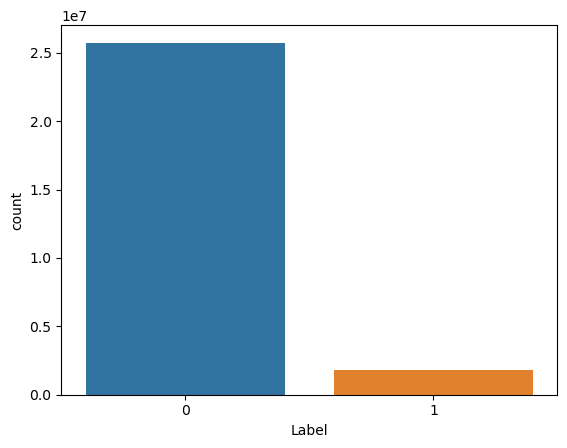

In [27]:
sns.countplot(new_df['Label'])

In [28]:
print("The Data is Imbalanced and the 0's label is :- ",float(len(new_df[new_df['Label'] == 0])/len(new_df[new_df['Label'] == 1]))," Times greater than 1's label")

The Data is Imbalanced and the 0's label is :-  14.078272394936171  Times greater than 1's label


In [30]:
#upsampling 1's to balance the data to match 0's shape
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
X = new_df.drop({'Label','datetime'},axis = 1)
Y = new_df['Label']   
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=5)

sm = SMOTE()   
dependent, label = sm.fit_resample(X_train, y_train.ravel())
print('Upsampling is completed')

final_df = dependent.copy()
final_df['Label'] = label

Upsampling is completed


<AxesSubplot:xlabel='Label', ylabel='count'>

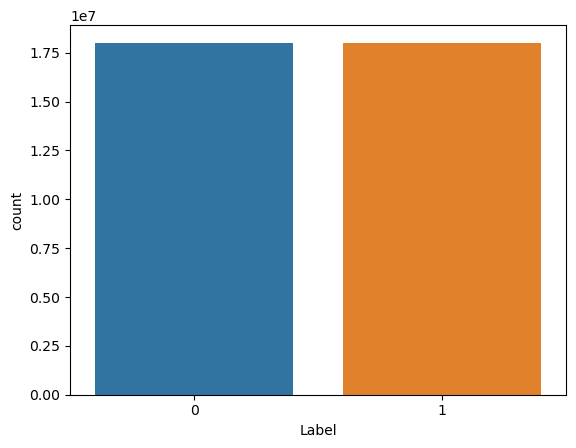

In [31]:
sns.countplot(final_df['Label'])

In [32]:
final_df.shape

(36031700, 9)

In [33]:
final_df.corr()

,acx,acy,acz,eda,blood_vol_pulse,h_rate,temp,Label
acx,1.000000,-0.143371,0.239859,-0.113417,0.077681,0.112037,-0.094673,0.044981
acy,-0.143371,1.000000,0.157477,0.114273,-0.122104,-0.194563,0.059828,-0.089979
acz,0.239859,0.157477,1.000000,-0.172916,-0.035387,0.009489,-0.068253,-0.045758
eda,-0.113417,0.114273,-0.172916,1.000000,-0.041664,0.015523,0.312531,0.102790
blood_vol_pulse,0.077681,-0.122104,-0.035387,-0.041664,1.000000,-0.056695,-0.018165,-0.013735
h_rate,0.112037,-0.194563,0.009489,0.015523,-0.056695,1.000000,0.100736,0.259214
temp,-0.094673,0.059828,-0.068253,0.312531,-0.018165,0.100736,1.000000,0.110208
Label,0.044981,-0.089979,-0.045758,0.102790,-0.013735,0.259214,0.110208,1.000000


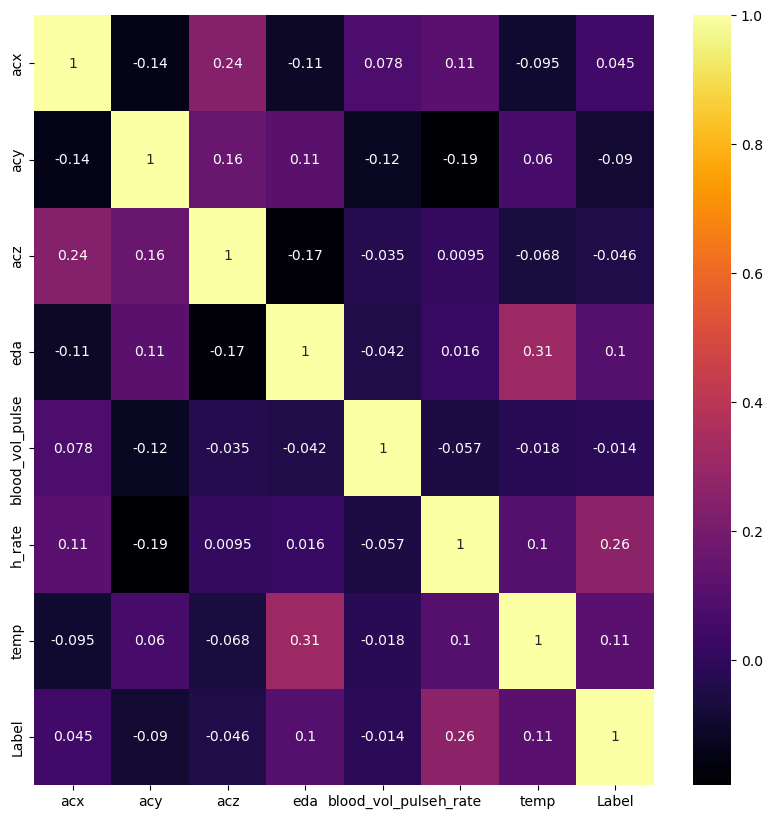

In [34]:
#"""Heat-map to check correlation visulization with the dependent variable"""
fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(final_df.corr().transpose(), cmap='inferno',annot = True)
plt.show()

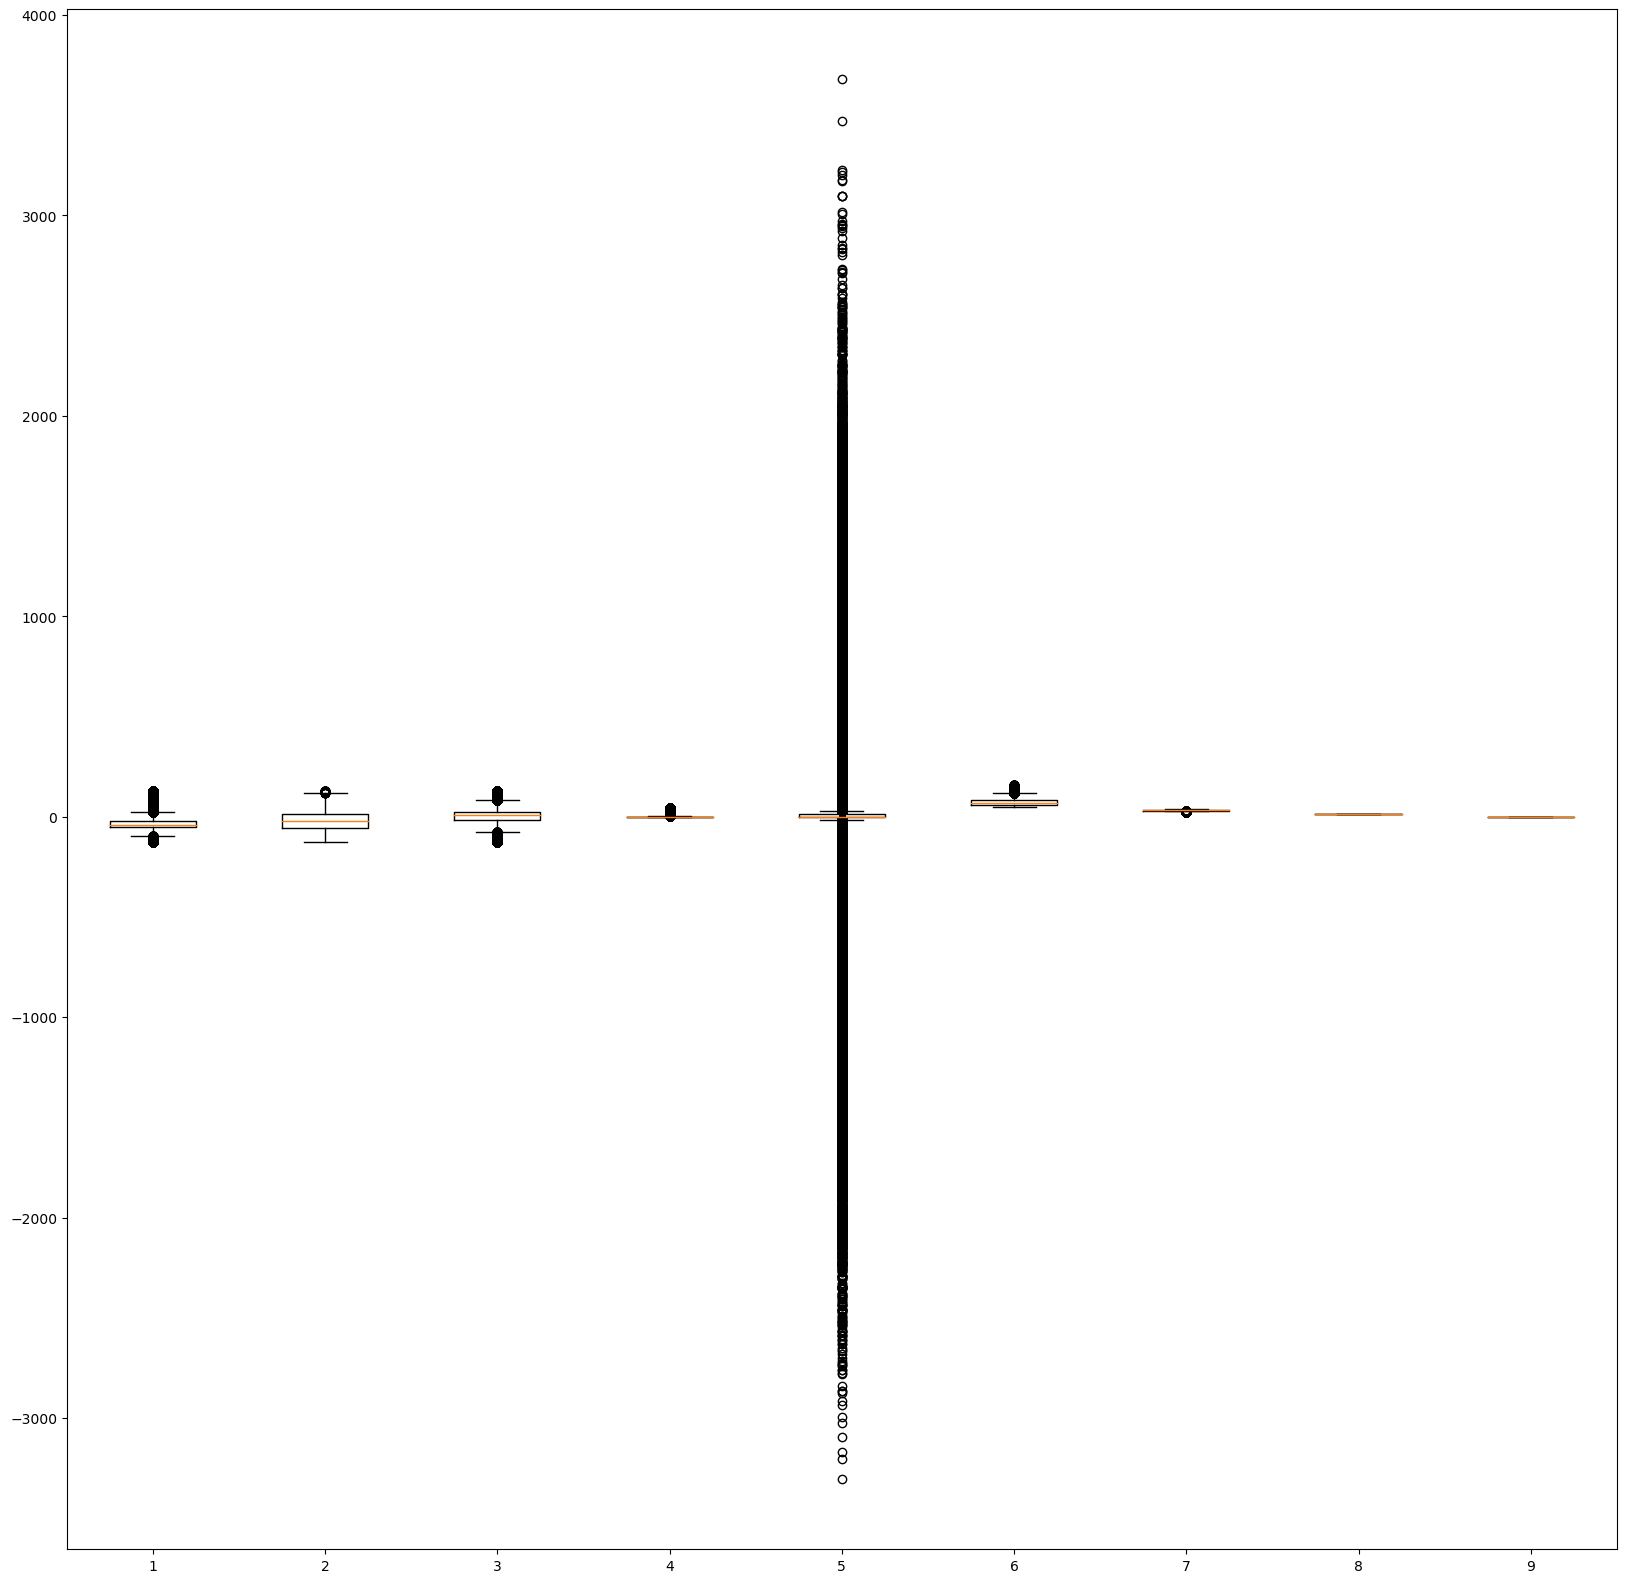

In [35]:
#"""Box plot to check the outlier of the data, which can be handled by Z-score during modelling"""
fig, ax = plt.subplots(figsize=(20,20))
plt.boxplot(final_df)
plt.show()

array([[<AxesSubplot:title={'center':'acx'}>,
        <AxesSubplot:title={'center':'acy'}>,
        <AxesSubplot:title={'center':'acz'}>],
       [<AxesSubplot:title={'center':'eda'}>,
        <AxesSubplot:title={'center':'blood_vol_pulse'}>,
        <AxesSubplot:title={'center':'h_rate'}>],
       [<AxesSubplot:title={'center':'temp'}>,
        <AxesSubplot:title={'center':'Label'}>, <AxesSubplot:>]],
      dtype=object)

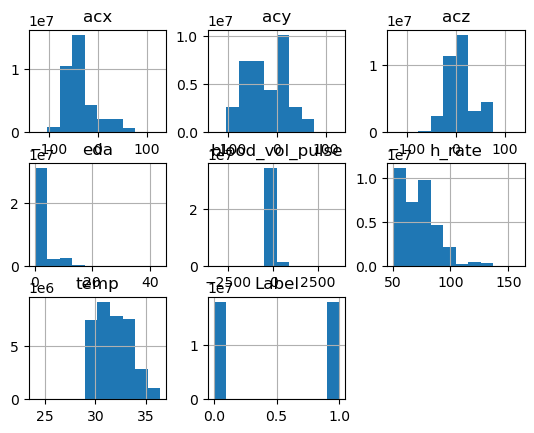

In [36]:
#All the data attribute appeard to be normally distributed except fotr 4th attribute and that us fine because trhat us datetime 
#attribute
final_df.hist()

# Timeseries data visulisation

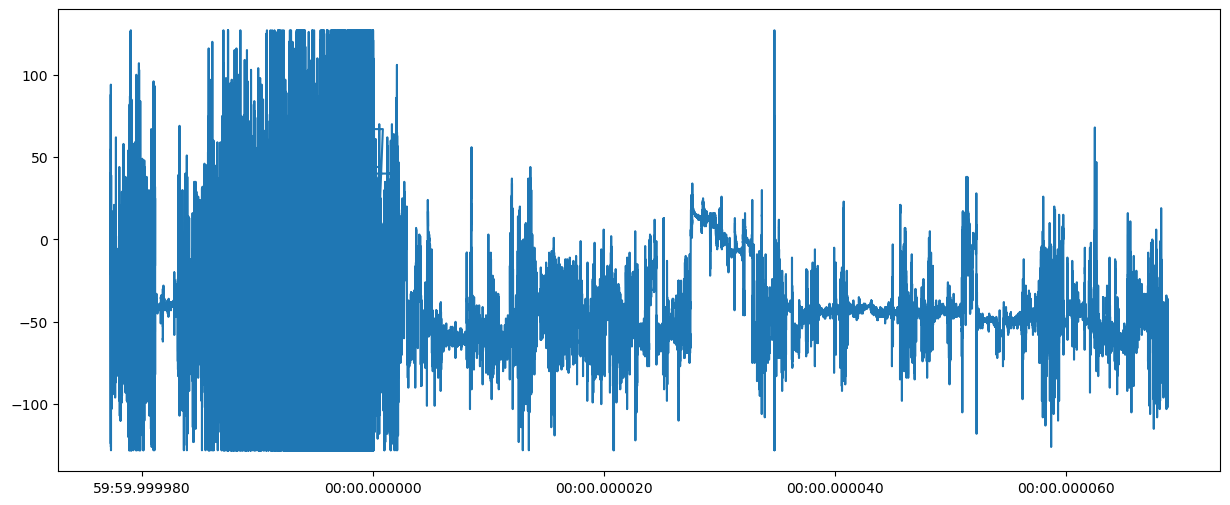

In [99]:
plt.figure(figsize=(15, 6))
print(plt.plot(new_df.datetime,new_df.acx))

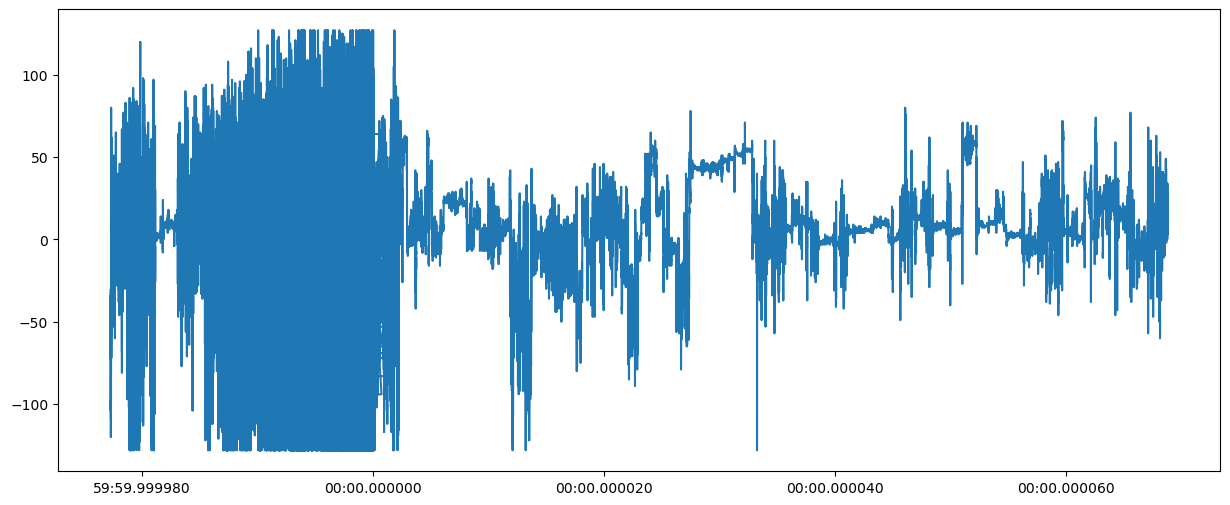

In [100]:
plt.figure(figsize=(15, 6))
print(plt.plot(new_df.datetime,new_df.acy))

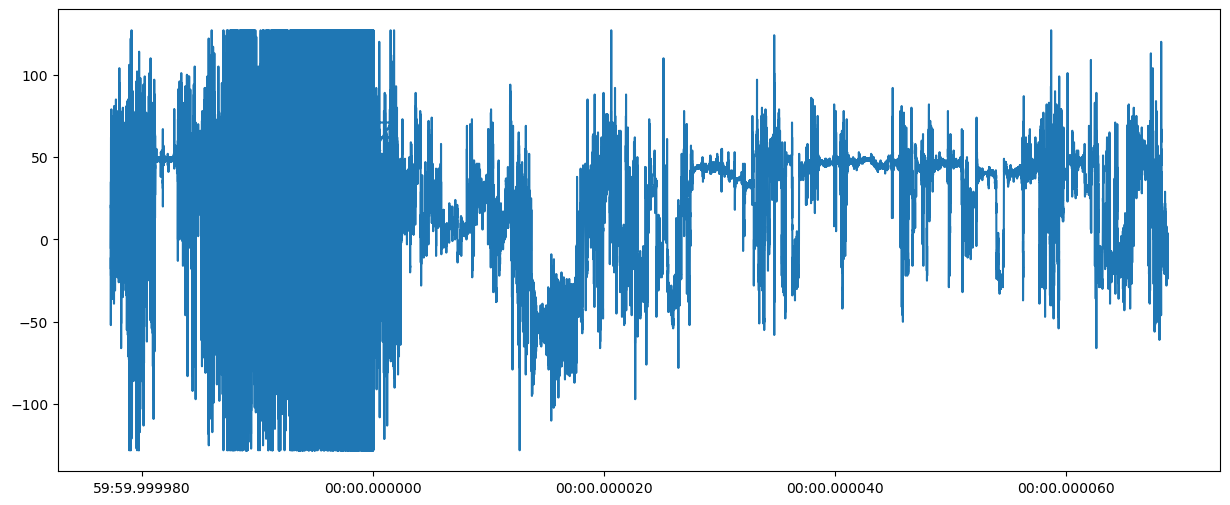

In [101]:
plt.figure(figsize=(15, 6))
print(plt.plot(new_df.datetime,new_df.acz))

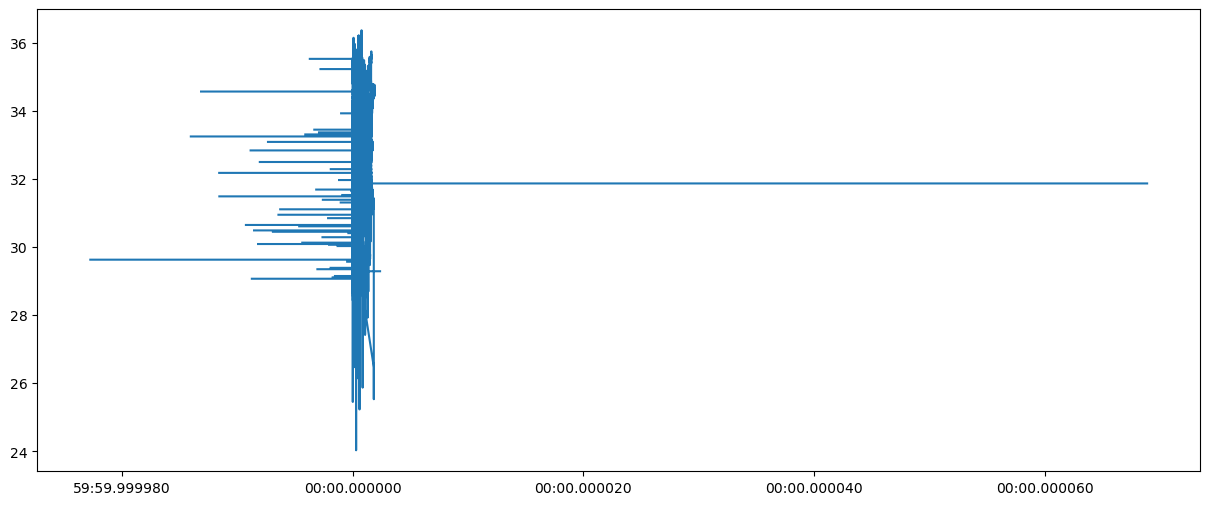

In [102]:
plt.figure(figsize=(15, 6))
print(plt.plot(new_df.datetime,new_df.temp))

# Spliting the data to train the model and test the model performance (Manual)

In [44]:
size = 0.80

#trainign 80% and testing 20%
training = final_df.iloc[:int(final_df.shape[0] * size)]
testing = final_df.iloc[int(final_df.shape[0] * size):]

X_train = training.drop({'Label','id'}, axis=1)
y_train = training['Label']
X_test = testing.drop({'Label','id'}, axis=1)
y_test = testing['Label']

# Output the shapes of the split data
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(28825360, 7) (28825360,) (7206340, 7) (7206340,)


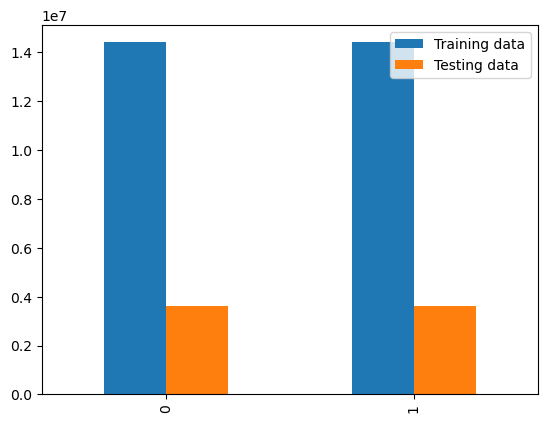

In [45]:
train_class_counts = pd.Series(y_train).value_counts()
test_class_counts = pd.Series(y_test).value_counts()

df = pd.DataFrame({'Training data': train_class_counts, 'Testing data': test_class_counts})
df.plot(kind='bar')
plt.show()

In [46]:
gc.collect()

13061

# Feature Selection

In [47]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [48]:
# feature selection """Pre defined fucntion of feature selection taken from web"""
def select_features(X_train, y_train, X_test):
 # configure to select all features
 fs = SelectKBest(score_func=f_classif, k='all')
 # learn relationship from training data
 fs.fit(X_train, y_train)
 # transform train input data
 X_train_fs = fs.transform(X_train)
 # transform test input data
 X_test_fs = fs.transform(X_test)
 return X_train_fs, X_test_fs, fs

In [49]:
#Tells us the scores of features which are best for model building 
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
 print('Feature %d: %f' % (i, fs.scores_[i]))

Feature 0: 58795.598069
Feature 1: 235849.550105
Feature 2: 60038.516010
Feature 3: 307830.214444
Feature 4: 5512.235521
Feature 5: 2077764.328541
Feature 6: 354885.603557


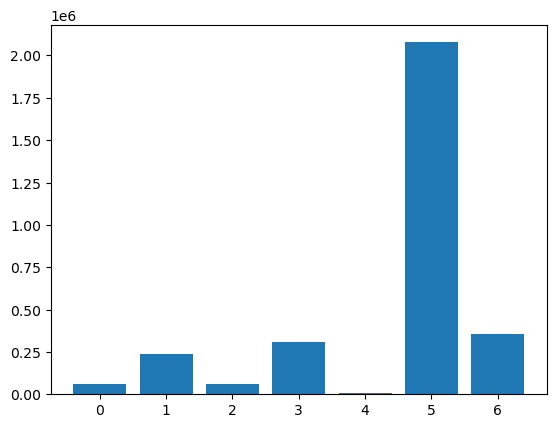

In [50]:
#Shows Which Feature is best for model building
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [51]:
gc.collect()

24068

# Normilisation

In [55]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [56]:
X_train.shape,X_test.shape

((28825360, 7), (7206340, 7))

# Model Building

# SGD Classifier

In [61]:
from sklearn import linear_model

SGD = linear_model.SGDClassifier()
SGD.fit(X_train,y_train)

SGDClassifier()


In [58]:
SGD_pred = SGD.predict(X_test)

In [67]:
print(classification_report(y_test, SGD_pred))

               precision    recall  f1-score   support
                                                      
           0        0.70      0.71      0.72   4457644
           1        0.71      0.70      0.72   4356788
                                                     
    accuracy                            0.72   8814432
   macro avg        0.70      0.70      0.72   8814432
weighted avg        0.70      0.70      0.72   8814432


In [75]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [73]:
#Confusion matrix representing True positive(TP), True Negative(NP), False Positive(FP), False Negative(FN)
con1 = confusion_matrix(y_test, SGD_pred)
con1

array([[4052021,  405623],
       [3900530,  456258]])

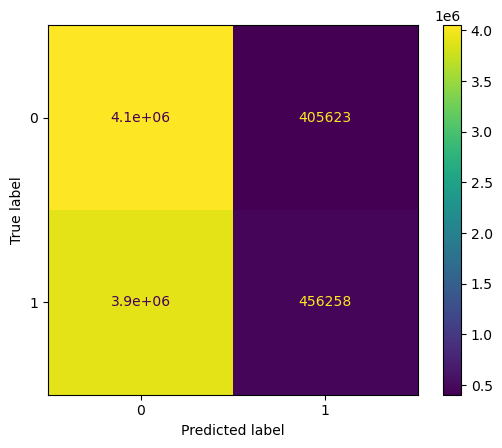

In [76]:
disp = ConfusionMatrixDisplay(confusion_matrix=con1)
disp.plot()

# Naive Bayes

In [77]:
from sklearn.naive_bayes import BernoulliNB

NB = BernoulliNB()

NB.fit(X_train,y_train)

BernoulliNB()


In [78]:
NB_pred = NB.predict(X_test)

In [79]:
print(classification_report(y_test, NB_pred))

               precision    recall  f1-score   support
                                                      
           0        0.60      0.43      0.50   4457644
           1        0.56      0.68      0.67   4356788
                                                     
    accuracy                            0.58   8814432
   macro avg        0.58      0.58      0.58   8814432
weighted avg        0.58      0.58      0.58   8814432


In [83]:
#Confusion matrix representing True positive(TP), True Negative(NP), False Positive(FP), False Negative(FN)
con2 = confusion_matrix(y_test, NB_pred)
con2

array([[3971046,  486598],
       [3853129,  503659]])

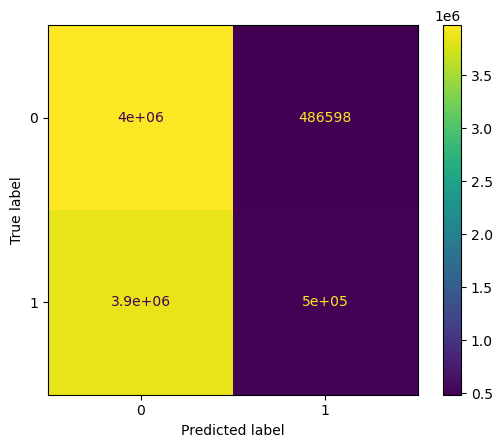

In [84]:
disp2 = ConfusionMatrixDisplay(confusion_matrix=con2)
disp2.plot()

# Random Forest

In [85]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(max_depth=2, random_state=0)
RF.fit(X_train,y_train)

RandomForestClassifier(max_depth=2, random_state=0)


In [86]:
RF_pred = RF.predict(X_test)

In [89]:
print(classification_report(y_test, RF_pred))

               precision    recall  f1-score   support
                                                      
           0        0.87      0.88      0.88   4457644
           1        0.88      0.87      0.89   4356788
                                                     
    accuracy                            0.90   8814432
   macro avg        0.90      0.90      0.90   8814432
weighted avg        0.90      0.90      0.90   8814432


In [90]:
#Confusion matrix representing True positive(TP), True Negative(NP), False Positive(FP), False Negative(FN)
con3 = confusion_matrix(y_test, RF_pred)
con3

array([[4201058,  256586],
       [4093199,  263589]])

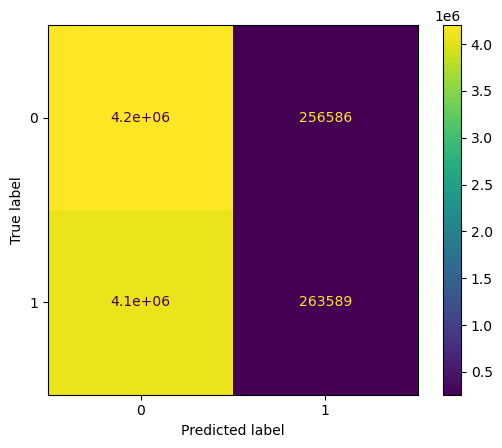

In [91]:
disp3 = ConfusionMatrixDisplay(confusion_matrix=con3)
disp3.plot()